In [1]:
using Plots, Printf, DelimitedFiles, MDToolbox
ENV["COLUMNS"] = 110; #display width for MDToolbox

┌ Info: Precompiling MDToolbox [7965e2f0-a35b-11e8-0207-19c030dd2def]
└ @ Base loading.jl:1423


In [2]:
# constants
KBT = KB_kcalpermol*300.0

0.59616123

In [3]:
# umbrella window centers
umbrella_center = 0:3:180
K = length(umbrella_center)

61

In [4]:
# define edges for histogram bin
M = 80; # number of bins
edge = range(-1, stop=181, length=M+1)
#edge = linspace(-1, 181, M+1)
bin_center = 0.5 .* (edge[2:end] .+ edge[1:(end-1)])

0.1375:2.275:179.8625

In [5]:
# read dihedral angle data
data_k = []
for k = 1:K
  filename = @sprintf "data/umbrella_alat/3_prod/run_%d.dat" umbrella_center[k]
  x = readdlm(filename);
  push!(data_k, x[:, 2])
end

In [6]:
# calculate u_kl
function minimum_image(center, x)
  dx = x .- center
  dx .= dx .- round.(dx./360.0).*360.0;
  dx
end

spring_constant = 200.0 * (pi/180.0)^2; # conversion of the unit from kcal/mol/rad^2 to kcal/mol/deg^2

u_kl = Matrix{Vector{Float64}}(undef, (K, K))
for k = 1:K
  for l = 1:K
      u_kl[k, l] = (spring_constant./KBT) .* (minimum_image(data_k[k], Float64(umbrella_center[l]))).^2
  end
end

In [7]:
# solve MBAR equations
f_k = mbar(u_kl)

iteration = 1  delta = 3.792207e+00  tol = 1.000000e-08
free energies =  0.000000 0.037324 0.020323 -0.003487 -0.011689 -0.003725 0.031821 0.046041 0.026918 0.030413 0.038951 0.002761 0.010686 0.062333 0.031915 -0.011487 -0.007096 0.057135 0.051225 0.040488 0.052074 0.059529 0.018827 0.042718 0.133334 0.235395 0.292114 0.287128 0.260171 0.274252 0.191234 0.098459 0.129140 0.052484 0.051695 0.032830 0.043973 0.074595 -0.010497 0.032336 0.089800 0.081554 0.059063 0.018211 0.021602 0.054682 0.052916 -0.010740 0.004204 0.009337 -0.041039 -0.000619 0.035841 0.024877 0.006035 -0.007298 0.033224 0.009686 -0.033100 -0.037420 0.061814

iteration = 2  delta = 1.812851e+00  tol = 1.000000e-08
free energies =  0.000000 0.045101 0.023600 -0.012264 -0.025992 -0.009552 0.043338 0.067772 0.048147 0.049477 0.053095 0.009748 0.022497 0.084096 0.045078 -0.014246 -0.005902 0.079794 0.085841 0.076317 0.089264 0.093699 0.051789 0.102850 0.255595 0.435679 0.543490 0.551457 0.515269 0.502048 0.363648 0.222902

61-element Vector{Float64}:
   0.0
   0.11769309323597753
   0.2286029366745563
   0.3837836738832279
   0.6442612588788448
   1.0091154850901667
   1.5016845530119007
   2.035369071643957
   2.561978733476481
   3.1256649919625374
   3.7393794475201148
   4.364234369621462
   5.030311879286216
   ⋮
  -6.674513245714762
  -7.563594371156242
  -8.25001215818648
  -8.924681638145616
  -9.565357267877992
 -10.166811767574778
 -10.656898656853697
 -11.03948444101731
 -11.434932571373928
 -11.735717780166226
 -11.87465265290697
 -11.806125792628691

In [8]:
w_k = mbar_weight(u_kl, f_k);

In [9]:
data_n = data_k[1]
w_n = w_k[1]
for k = 2:K
    data_n = [data_n; data_k[k]]
    w_n = [w_n; w_k[k]]
end

In [10]:
M = 80; # number of bins
edge = range(-1, stop=181, length=M+1)

pmf_m, bin_center = ksdensity(data_n, grid_x=edge, weight=w_n, boxsize=360.0, bandwidth=edge[2]-edge[1])
pmf_m .= - KBT .* log.(pmf_m)
pmf_m .-= pmf_m[1]
pmf_m'

1×81 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.0336801  0.0889877  0.138797  0.200929  …  -6.87265  -6.99528  -7.06232  -7.04624  -6.99539

In [11]:
using BSON: @save
@save "mbar.bson" bin_center pmf_m

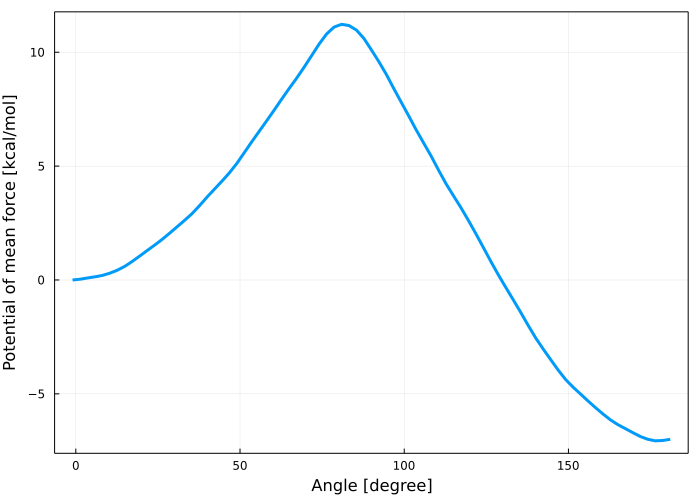

In [12]:
p = plot(bin_center, pmf_m, linewidth=3, label=nothing, framestyle=:box, dpi=350, size=(700, 500))
xlabel!("Angle [degree]", fontsize=100)
ylabel!("Potential of mean force [kcal/mol]", fontsize=100)

In [13]:
savefig(p, "mbar.png")

# Compare WHAM and MBAR

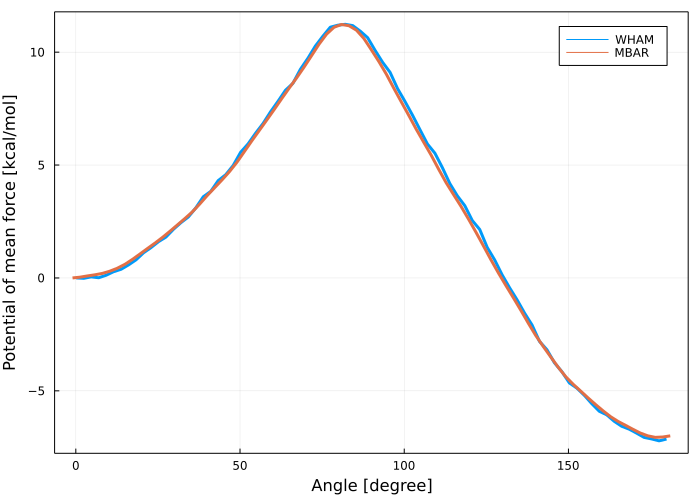

In [14]:
using BSON: @load

@load "wham.bson" bin_center pmf_m
b_wham = bin_center
p_wham = pmf_m[:]

@load "mbar.bson" bin_center pmf_m
b_mbar = bin_center
p_mbar = pmf_m

p = plot(b_wham, p_wham, linewidth=3, label="WHAM", framestyle=:box, dpi=350, size=(700, 500))
plot!(b_mbar, p_mbar, linewidth=3, label="MBAR", framestyle=:box, dpi=350, size=(700, 500))
xlabel!("Angle [degree]", fontsize=100)
ylabel!("Potential of mean force [kcal/mol]", fontsize=100)

In [15]:
savefig(p, "wham_mbar.png")